# Bounds on the number of samples of size $k$ from a population of size $n$ for various PRNGs and sampling algorithms

This notebook uses entropy-based bounds to find upper bounds on the number of samples that can be generated using a variety of algorithms for generating pseudo-random numbers (PRNs) and for turning sequences of PRNs into samples.

+ a hypothetical sampling algorithm that uses an optimal coding of samples to turn strings of $\log_2{n \choose k}$ bits into samples of size $k$
+ a common algorithm that involves assigning a PRN to each of the $n$ elements, then taking those elements assigned the smallest $k$ numbers to be the sample
+ algorithm R, a streamable algorithm that also uses at least one PRN per element of the population, but avoids the sort.
+ algorithm S of Knuth, another reservoir method
+ algorithm Random-Sample on p. 130 of [Cormen et al. (2009)](https://mitpress.mit.edu/books/introduction-algorithms)

PRNGs considered include [linear congruential generators](https://en.wikipedia.org/wiki/Linear_congruential_generator) (LCGs, including [RANDU](https://en.wikipedia.org/wiki/RANDU)), and the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister). The behavior of the [middle square method](https://en.wikipedia.org/wiki/Middle-square_method) is presumably worse. There is some discussion of using the SHA256 cryptographic hash function to generate PRNs.

[Kellie Ottoboni](http://www.stat.berkeley.edu/~kellieotto/) and [Philip B. Stark](www.stat.berkeley.edu/~stark)



## References

1. Cormen, T.H., C.E. Leiserson, R.L. Rivest and C. Stein, 2009. _Introduction to Algorithms, 3rd edition_, MIT Press.
1. Knuth, D., 1997 _The Art of Computer Programming, V.II: Seminumerical methods_, 3rd edition, Addison-Wesley, Boston.
1. L'Ecuyer, P. and R. Simard, 2007. TestU01: A C Library for Empirical Testing of Random Number Generators, _ACM Trans. Math. Softw._, _33_, http://doi.acm.org/10.1145/1268776.1268777
1. Marsaglia, G., 1968. Random Numbers Fall Mainly in the Planes, _PNAS_, _61_, 25&ndash;28.
1. Marsaglia, G., 2003. Xorshift RNGs. _Journal of Statistical Software_, _8_, 1&ndash;6.
1. Shannon, C.E., 1948. A Mathematical Theory of Communication, _Bell System Technical Journal, 27_, 379&ndash;423, 623&ndash;656. 
1. Vitter, J.S., 1985. Random Sampling with a Reservoir, _ACM Transactions on Mathematical Software, 11_, 37&ndash;57.
1. Wikipedia articles

## Pseudo-random number generators (PRNGs)

Most computers cannot generate true random numbers.

Instead, starting with a "seed" value, use algorithms called PRNGs to generate deterministic sequences.

Depending on the quality of the PRNG, the sequences behave more or less like sequences of random numbers.

Each time a number is generated, the PRNG's "state" changes.

Must consider fitness for use of PRNGs. What's "good enough?"

## Properties of PRNGs

+ number of states
    - dimension of state space in bits
+ period
    - maximum over initial states of the number of states visited before repeating
    - period &le; number of states
    - if state has $s$ bits, period $\le 2^s$
    - for some PRNGs, period is much less than number of states
    - for some seeds for some PRNGs, number of states visited much less than period
+ $k$-distribution
    - suppose $\{X_i\}$ is sequence of $P$ $w$-bit integers
    - define $t_v(X_i)$ to be the first $v$ bits of $X_i$
    - define the $P$ $. A pseudorandom sequence xi of w-bit integers of period P is said to be k-distributed to v-bit accuracy if the following holds.
Let truncv(x) denote the number formed by the leading v bits of x, and consider P of the kv-bit vectors
{\displaystyle ({\text{trunc}}_{v}(x_{i}),\,{\text{trunc}}_{v}(x_{i+1}),\,...,\,{\text{trunc}}_{v}(x_{i+k-1}))\quad (0\leq i<P)} .
Then each of the 2kv possible combinations of bits occurs the same number of times in a period, except for the all-zero combination that occurs once less often.
+ sensitivity to initial state; burn-in

## Some PRNGs

### Middle Square

### RANDU

### General linear congruential (LCG)

### Mersenne Twister (MT)

### xorshift family

Originated by Marsaglia, 2003.

Vigna, S., 2014. Further scramblings of Marsaglia's xorshift generators. https://arxiv.org/abs/1404.0390

128-bit xorshift+ 

    uint64_t s[2];

    uint64_t xorshift128plus(void) {
	    uint64_t x = s[0];
	    uint64_t const y = s[1];
	    s[0] = y;
	    x ^= x << 23; // a
	    s[1] = x ^ y ^ (x >> 17) ^ (y >> 26); // b, c
	    return s[1] + y;
    }
    
    
1024-bit xorshift+

    uint64_t s[16];
    int p;
    
    uint64_t next(void) {
        const uint64_t s0 = s[p];
        uint64_t s1 = s[p = (p + 1) & 15];
        const uint64_t result = s0 + s1;
        s1 ^= s1 << 31; // a
        s[p] = s1 ^ s0 ^ (s1 >> 11) ^ (s0 >> 30); // b, c
    return result;
}

xorshift+ passes all the tests in BigCrush, has 128-bit state space and period $2^{128}-1$, but is 
only $(k-1)$-dimensionally equidistributed, where $k$ is the dimension of the distribution of the xorshift
generator from which it's derived. E.g., for the 128-bit version, xorshift+ is only 1-dimensionally equidistributed.

### Methods based on cryptographic hash functions

Cryptographic hash functions have several basic properties:

1. produce fixed-length "digest" of an arbitrarily long "message": $H:\{0, 1\}^* \rightarrow \{0, 1\}^L$.
1. inexpensive to compute
1. non-invertible ("one-way," hard to find pre-image of any hash except by exhaustive enumeration)
1. collision-resistant (hard to find $M_1 \ne M_2$ such that $H(M_1) = H(M_2)$)
1. small change to input produces big change to output ("unpredictable," input and output effectively independent)
1. equidistributed: bits of the hash are essentially random 

Summary: as if $H(M)$ is random $L$-bit string is assigned to $M$ in a way that's essentially unique.

#### Hash-based PRNG

Generate a random string $S$ of reasonable length, e.g., 20 digits.

$$ X_i = {\mbox{Hash}}(S+i),$$

where $+$ denotes string concatenation, and the resulting string is interpreted as a (long) hexadecimal number.

Sample implementation in Python by Ron Rivest: http://people.csail.mit.edu/rivest/sampler.py

Sample implementation in angular-js by Chris Jerdonek: https://github.com/cjerdonek/quick-sampler

Sample implementation in JavaScript: https://www.stat.berkeley.edu/~stark/Java/Html/sha256Rand.htm

## Tests of PRNGS

### Knuth (1969) _The Art of Computer Programming_, v.2 

+ Many $\chi^2$-based tests
+ Kolmogorov-Smirnov

### Marsaglia (1996) DIEHARD tests

+ Birthday spacings
+ Overlapping permutations of 5 random numbers
+ Ranks of binary matrices of various dimensions
+ Monkeys at typewriters: count overlapping "words" in strings of bits
+ Count the 1s in bytes; translate to "words."
+ Parking lot test, 100 &times; 100 square lot. Count non-collisions.
+ Minimum distance test: Min distance between 8,000 random points in a 10,000 &times; 10,000 square. 
+ Sphere-packing in a cube at random; diameter of smallest sphere.
+ Squeeze test: Multiply 231 by random floats on (0,1) until hitting 1.
+ Overlapping sums of 100 random (0,1) floats.
+ Runs test for random floats
+ #wins and # rolls in 200,000 games of craps

### L’Ecuyer and Simard (2007) TestU01 http://dl.acm.org/citation.cfm?doid=1268776.1268777

+ Kolmogorov-Smirnov, Cr&aacute;mer-von Mises, Anderson-Darling, clustering, run and gap, hits in partition of a hypercube (collisions, empty cells, time between visits, ...), birthday spacings, close pairs, coupon collector, sum collector, complexity of bit strings (linear complexity, jump complexity, jump size complexity, Lempel-Ziv complexity), spectral tests on bit strings, autocorrelation of bits, runs and gaps in bits, ..., ranks of binary matrices, longest runs, Hamming weights, random walks, close pairs of binary sequences, 

## Random sampling

## Entropy bounds on combinations

Bound ${n \choose k}$ using the inequality

$$ \frac{2^{nH(k/n)}}{n+1} \le {n \choose k} \le 2^{nH(k/n)}$$

In [1]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import scipy as sp
from scipy.misc import comb, factorial
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def H(p):  # entropy of a Bernoulli(q) variable
    return -p*math.log(p, 2) - (1-p)*math.log(1-p, 2)


def Hcomb(n,k):  # entropy of simple random sampling of k of n 
    # entropy is -\sum p_i \log_2 p_i. Here, all p_i=1/nCk.
    return -math.log(1/comb(n,k), 2)
    

def comb_upper_bound(n, k):  # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))


def comb_lower_bound(n, k): # entropy upper bound on nCk
    p = k/n
    return 2**(n*H(p))/(n+1)

In [3]:
# number of bits per period divided by log_2(choose(n,k))?
def sample_counter(n, k, period, word_length):
    return (period*word_length) > math.log(comb(n, k), 2)*comb(n, k)


def sample_counter_lb(n, k, period, word_length):
    ub_bits_for_all_samples = (n*H(k/n) - math.log(n+1, 2))*(2**(n*H(k/n)))/(n+1)
    return (period*word_length) > ub_bits_for_all_samples

## LCGs

$$ X_{n+1} = (aX_n +c)\mod m.$$

LCG period is at most $m$.

### Hull-Dobell Theorem: the period of an LCG is $m$ for all seeds $X_0$ iff

+ $m$ and $c$ are relatively prime
+ $a-1$  is divisible by all prime factors of $m$
+ $a-1$  is divisible by 4 if $m$ is divisible by 4


# RANDU
The next few computations are specific to the RANDU PRNG, a particularly bad [LCG](https://en.wikipedia.org/wiki/Linear_congruential_generator) promulgated in the 1960s and widely copied.

RANDU is given by the recursion

$$ X_{j+1} = 65539 X_j\mod 2^{31}.$$

Triples of values from RANDU fall on 15 planes in 3-dimensional space, as shown below.

In [9]:
# RANDU constants
A = 0
M = 2**31
B = 65539

randu_period = 2**29
randu_word_length = 32

def nextRand(x):
    y = A + (B * x) % M
    return y

In [10]:
# generate triples using RANDU
x = 1234567890  # seed
reps = 100000
xs = np.ndarray(shape = (3,reps))
for i in range(reps):
    x = nextRand(x)
    xs[0][i] = x
    x = nextRand(x)
    xs[1][i] = x
    x = nextRand(x)
    xs[2][i] = x

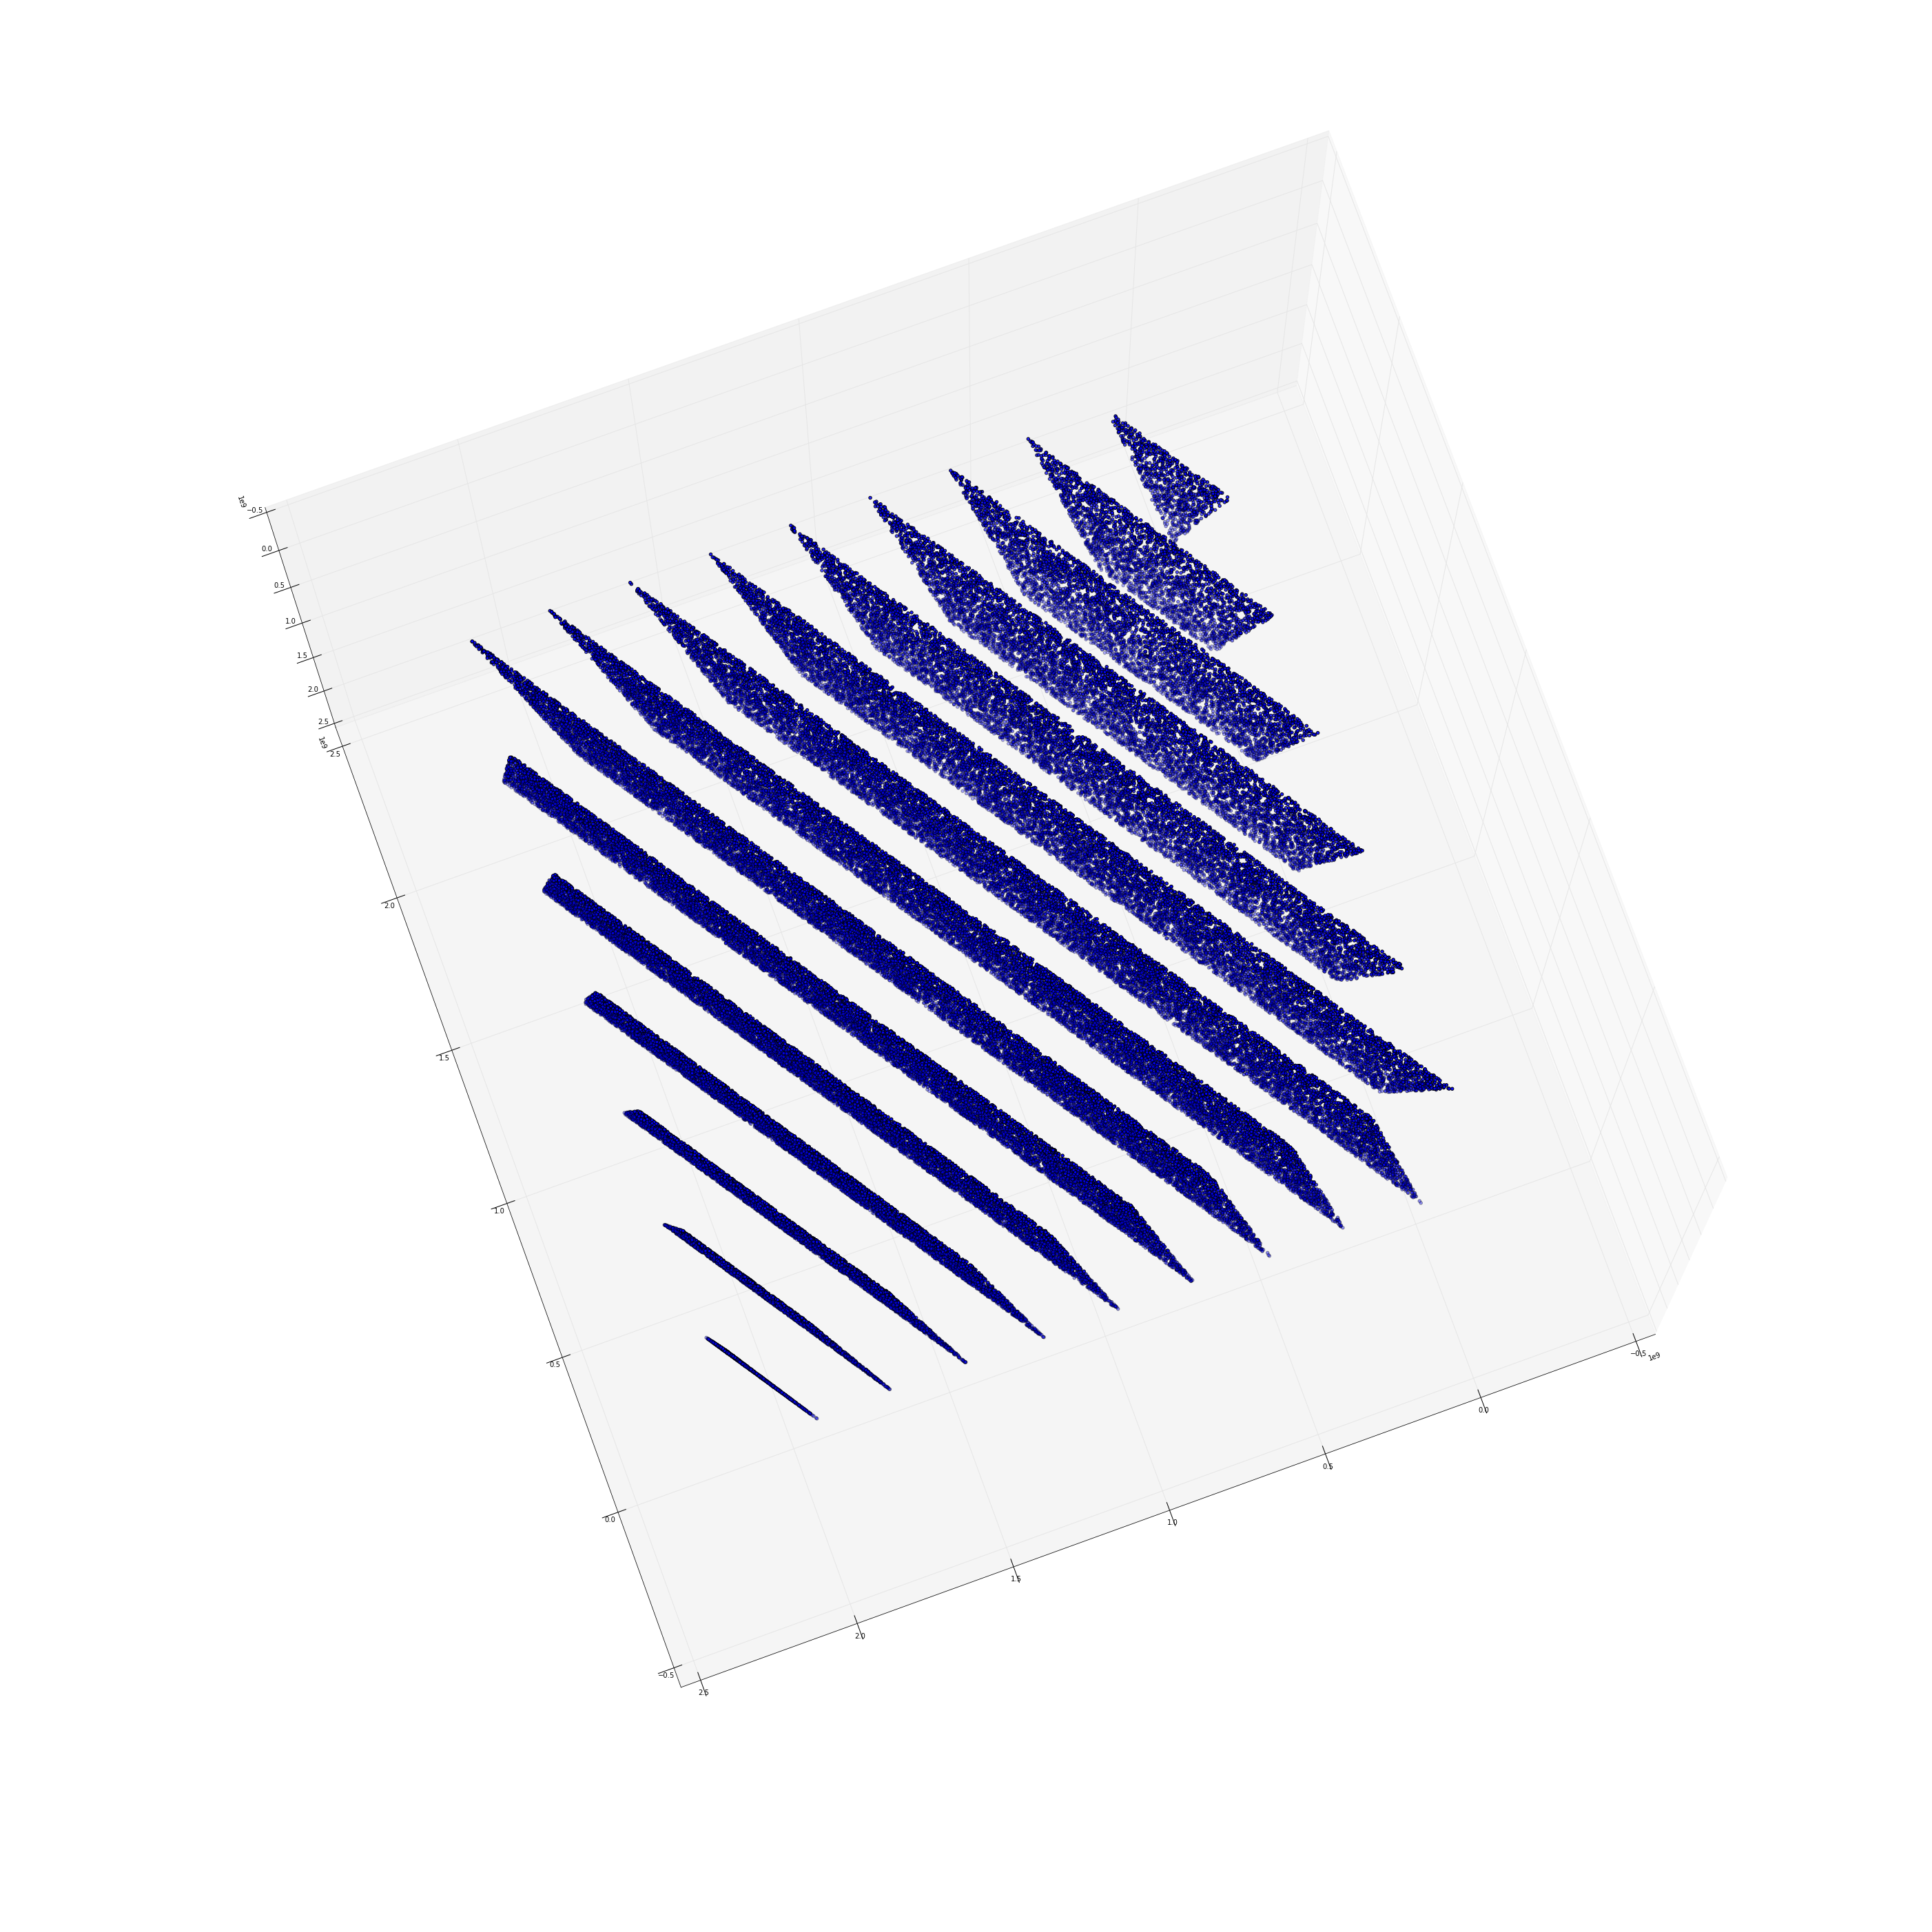

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[0],xs[1], xs[2])
plt.rcParams['figure.figsize'] = (40.0, 40.0) 

ax.view_init(-100,110)

plt.show()

In [7]:
n = 30
k = 20
can_do = True
period = randu_period
word_length = randu_wordlength

while can_do:
    n = n+1
    can_do = sample_counter_lb(n, k, period, word_length)
    print n
print "for randu, can't do ",n

NameError: name 'randu_wordlength' is not defined

# Most efficient coding/a single period of the PRNG

Suppose we generate samples of size $k$ from a population of size $n$.
There are ${n \choose k}$ such samples.
The most efficient coding scheme requires $\log_2{n \choose k}$ bits to encode all possible samples.

A PRNG generates a "word" (typically an integer) using a fixed number of bits.
The period of the PRNG tells us the maximum number of words the PRNG can generate starting from a particular seed.
The period times the word length is the number of random bits that the PRNG can generate.
If this number is less than the number of bits per sample encoding times the number of samples, ${n \choose k}\log_2{n \choose k}$, then it is not possible to generate all possible samples in one period of the PRNG.

For a particular PRNG with known period and word length (typically 32 bits), we can fix $k$ and calculate the largest $n$ for which the PRNG can generate all possible samples.
Similarly, we can fix $n$ and find the largest $k$ for which the PRNG can generate all possible samples.
Note, when we vary $k$ it is only interesting for $1 \leq k \leq \lfloor{\frac{n}{2}}\rfloor$.
Without loss of generality, if $k > \lfloor{\frac{n}{2}}\rfloor$, we can think of the sampling as selecting individuals to *exclude* from the sample.

For large $n$, it's costly to compute binomial coefficients.
Instead, we use the following bound:

$$ \frac{2^{nH(k/n)}}{n+1} \leq {n \choose k} \leq 2^{nH(k/n)}$$

When dealing with the Mersenne Twister, we substitute the lower bound for ${n \choose k}$, giving overly optimistic estimates of maximum $n$.

## RANDU

In [ ]:
k = [20, 50, 100, 500]
maxn = [0, 0, 0, 0]
i = 0
step_size = 10
for kk in k:
    can_do = True
    n = kk
    while can_do:
        n = n + step_size
        can_do = sample_counter_lb(n, kk, randu_period, randu_word_length)
#    print n
    
    count = lambda x: randu_period*randu_word_length - math.log(comb(x, kk), 2)*comb(x, kk)
    if kk==(n-step_size):
        llim = n - step_size + 1
    else:
        llim = n - step_size
    maxn[i] = np.trunc(brentq(count, llim, n))
    i = i + 1
    
print(maxn)

In [ ]:
n = [10, 20, 50, 100]
maxk = [0, 0, 0, 0]
i = 0
step_size = 1
for nn in n:
    can_do = True
    k = 0
    while can_do and k < nn/2:
        k = k + step_size
        can_do = sample_counter(nn, k, randu_period, randu_word_length)
    maxk[i] = k
    i = i + 1
    
print(maxk)

## Mersenne Twister

In [ ]:
mersenne_twister_period = (2**19937) - 1
mersenne_twister_word_length = 32

In [ ]:
n = 100
k = 100
can_do = True
while can_do and n<1000000:
    n = n+1000
    can_do = sample_counter_lb(n, k, mersenne_twister_period, mersenne_twister_word_length)
    print n
print "can't do ",n

In [ ]:
k = [50, 100]
maxn = [0, 0]
i = 0
step_size = 10**4
for kk in k:
    can_do = True
    n = kk
    while can_do:
        n = n + step_size
        can_do = sample_counter_lb(n, kk, mersenne_twister_period, mersenne_twister_word_length)
    
    # This doesn't seem to work. I wonder if it's a problem with long int math.
#    count = lambda x: mersenne_twister_period*mersenne_twister_word_length - long((x*H(kk/x) - math.log(x+1, 2))*(2**(x*H(kk/x))/(x+1)))
#    maxn[i] = brentq(count, n-step_size, n)
    while not can_do:
        n = n - 1
        can_do = sample_counter_lb(n, kk, mersenne_twister_period, mersenne_twister_word_length)
    maxn[i] = n
    i = i + 1
    step_size = step_size/100
print maxn

# Naive Sampling Algorithm

The "naive sampling algorithm" is the algorithm that assigns a PRN to each item, then sorts and takes top k.
We ask:
- can all permutations occur?
- can all $nPk$ permutations occur?
- can all $nCk$ samples occur?

We look at RANDU and the Mersenne Twister.
Unfortunately, due to overflow errors, we don't have results for the Mersenne Twister yet.

In [ ]:
# All permutations

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long((2**(nn*H(kk/nn))/(nn+1)))
        if count(10000)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 10000)
        j = j + 1
    i = i + 1
print(all_perm)

In [ ]:
# can all nPk permutations occur?

k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long(factorial(nn)/factorial(kk))
        if count(150)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 150)
        j = j + 1
    i = i + 1
print(all_perm)

In [ ]:
# What's the largest n for which all nCk samples can occur?


k = np.array([10, 20, 50, 100])
all_perm = np.zeros((4, 2))
period_lengths = np.array([randu_period, mersenne_twister_period])
i = 0
for kk in k:
    j = 0
    for p in period_lengths:
        count = lambda nn: p - long(comb(nn,kk))
        if count(150)>0:
            all_perm[i, j] = -99
        else:
            all_perm[i, j] = brentq(count, kk+1, 150)
        j = j + 1
    i = i + 1
print(all_perm)

## Vitter (1985) Algorithm R

## Algorithm S

## Something else?

## Cormen et al. (2009) Random-Sample

## Best Practices

+ Use a source of real randomness to set the seed, e.g., rolls of 10-sided dice.
+ Record the seed so your analysis is reproducible.
+ Use a PRNG at least as good as the Mersenne Twister. Avoid linear congruential generators and the Wichmann-Hill generator.
+ Use open-source software, and record the version of the software you use.
+ Use a sampling algorithm that does not "waste randomness." Avoid permuting the entire population.
+ Consider the size of the problem: are your PRNG and sampling algorithm adequate?
+ Avoid "tests of representativeness." They alter the distribution of the sample.


# testing out bounds when factorial overflows

In [ ]:
factorial(41400)

In [ ]:
print comb(41400,100)
print comb_upper_bound(41400, 100)
print comb_lower_bound(41400, 100)